In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from galton import galton_rvs, galton_rvs_ratio
from keras.utils import to_categorical


Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from galton import n_nails 
from galton import n_rows
theta_0 = -0.8
theta_1 = -0.6

# Density estimation with histograms

In [3]:
samples_0, _, scores_0, _ = galton_rvs(theta_0, n_runs=20000, random_state=1234)
p_estimated_0, _ = np.histogram(samples_0, bins=n_nails, range=(0, n_nails), density=True)

samples_1, _, scores_1, _ = galton_rvs(theta_1, n_runs=20000, random_state=1234)
p_estimated_1, _ = np.histogram(samples_1, bins=n_nails, range=(0, n_nails), density=True)

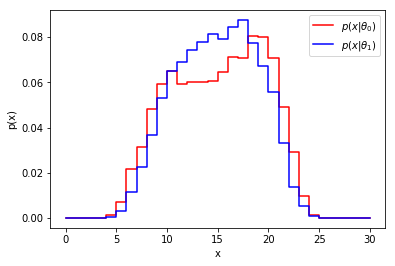

In [4]:
plt.step(range(len(p_estimated_0)), p_estimated_0,
         c='r', lw=1.5,
         label=r'$p(x|\theta_0)$')
plt.step(range(len(p_estimated_0)), p_estimated_1,
         c='b', lw=1.5, 
         label=r'$p(x|\theta_1)$')

plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend()
plt.show()

# NDE + SCANDAL

In [5]:
from galton import check_random_state

def draw(n_samples, n_thetas=10, random_state=0):
    n_traces_per_theta = n_samples // n_thetas
    
    all_x = []
    all_t_xz = []
    all_thetas = []
    
    for k, theta in enumerate(np.linspace(-1.0, -0.4, n_thetas)):
        x, log_p_xz, t_xz, _ = galton_rvs(theta, n_runs=n_traces_per_theta, random_state=random_state+k)
        all_x.append(x)
        all_t_xz.append(t_xz)
        all_thetas.append(theta * np.ones(n_traces_per_theta))
        
    all_x = np.array(all_x).reshape(-1, 1)
    all_x = to_categorical(all_x, num_classes=n_nails)
    all_t_xz = np.array(all_t_xz).reshape(-1, 1)
    all_thetas = np.array(all_thetas).reshape(-1, 1)
    
    rng = check_random_state(random_state)
    choices = rng.choice(len(all_x), len(all_x), replace=False)
        
    return all_x[choices], all_t_xz[choices], all_thetas[choices]

In [6]:
x, t_xz, theta = draw(10000)

In [7]:
n_features = 1 
hidden_size = 10
n_outputs = n_nails

In [8]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Lambda, dot
from keras.models import Model
import keras.backend as K

def make_nde(lr=0.001):   
    theta = Input(shape=(1,))
    h = Dense(hidden_size, activation="tanh")(theta)
    phat_theta = Dense(n_outputs, activation="softmax")(h)
    
    model = Model(inputs=[theta], outputs=[phat_theta])
    opt = Adam(lr=lr)
    model.compile(loss=["categorical_crossentropy"], optimizer=opt)
    
    return model

def make_scandal(lr=0.001):
    theta = Input(shape=(1,))
    h = Dense(hidden_size, activation="tanh")(theta)
    phat_theta = Dense(n_outputs, activation="softmax")(h)
    
    x = Input(shape=(n_outputs,))
    phat_x_theta = dot([x, phat_theta], axes=1) 
    t_x = Lambda(lambda exp: K.gradients(K.log(exp[0]), [exp[1]])[0], 
                 output_shape=(n_features,))([phat_x_theta, theta])
    
    model = Model(inputs=[theta, x], outputs=[phat_theta, t_x])
    opt = Adam(lr=lr)
    model.compile(loss=["categorical_crossentropy", "mse"], optimizer=opt)
    
    return model

In [9]:
nde = make_nde()
nde.fit(theta, x, batch_size=32, epochs=50)

Epoch 1/50
10000/10000 [==============================] - 0s - loss: 3.1473     
Epoch 2/50
10000/10000 [==============================] - 0s - loss: 2.8610     
Epoch 3/50
10000/10000 [==============================] - 0s - loss: 2.8342     
Epoch 4/50
10000/10000 [==============================] - 0s - loss: 2.8269     
Epoch 5/50
10000/10000 [==============================] - 0s - loss: 2.8234     
Epoch 6/50
10000/10000 [==============================] - 0s - loss: 2.8214     
Epoch 7/50
10000/10000 [==============================] - 0s - loss: 2.8202     
Epoch 8/50
10000/10000 [==============================] - 0s - loss: 2.8188     
Epoch 9/50
10000/10000 [==============================] - 0s - loss: 2.8171     
Epoch 10/50
10000/10000 [==============================] - 0s - loss: 2.8166     
Epoch 11/50
10000/10000 [==============================] - 0s - loss: 2.8154     
Epoch 12/50
10000/10000 [==============================] - 0s - loss: 2.8136     
Epoch 13/50
10000/10000 [

In [10]:
scandal = make_scandal()
scandal.fit([theta, x], [x, t_xz], batch_size=32, epochs=50)

Epoch 1/50
10000/10000 [==============================] - 0s - loss: 5.2170 - dense_4_loss: 3.3163 - lambda_1_loss: 1.9007     
Epoch 2/50
10000/10000 [==============================] - 0s - loss: 4.2410 - dense_4_loss: 3.0189 - lambda_1_loss: 1.2220     
Epoch 3/50
10000/10000 [==============================] - 0s - loss: 3.9374 - dense_4_loss: 2.8760 - lambda_1_loss: 1.0614     
Epoch 4/50
10000/10000 [==============================] - 0s - loss: 3.8425 - dense_4_loss: 2.8270 - lambda_1_loss: 1.0155     
Epoch 5/50
10000/10000 [==============================] - 0s - loss: 3.7990 - dense_4_loss: 2.8074 - lambda_1_loss: 0.9915     
Epoch 6/50
10000/10000 [==============================] - 0s - loss: 3.7750 - dense_4_loss: 2.7986 - lambda_1_loss: 0.9763     
Epoch 7/50
10000/10000 [==============================] - 0s - loss: 3.7595 - dense_4_loss: 2.7937 - lambda_1_loss: 0.9658     
Epoch 8/50
10000/10000 [==============================] - 0s - loss: 3.7498 - dense_4_loss: 2.7905 - lam

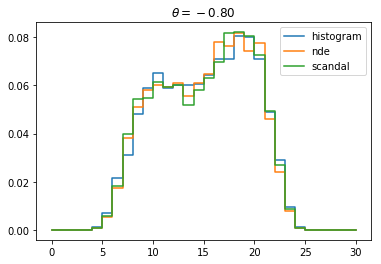

In [11]:
plt.step(range(n_nails), p_estimated_0, label="histogram")
plt.step(range(n_nails), nde.predict(np.array([theta_0])).ravel(), label="nde")
plt.step(range(n_nails), scandal.predict([np.array([[theta_0]]), np.zeros((1, n_nails))])[0][0], label="scandal")
plt.legend()
plt.title(r"$\theta=%.2f$" % theta_0)
plt.show()

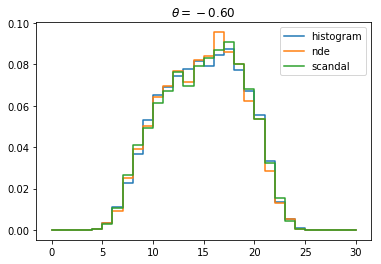

In [12]:
plt.step(range(n_nails), p_estimated_1, label="histogram")
plt.step(range(n_nails), nde.predict(np.array([theta_1])).ravel(), label="nde")
plt.step(range(n_nails), scandal.predict([np.array([[theta_1]]), np.zeros((1, n_nails))])[0][0], label="scandal")
plt.legend()
plt.title(r"$\theta=%.2f$" % theta_1)
plt.show()

# CARL

In [13]:
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from carl.ratios import ClassifierScoreRatio
from carl.learning import CalibratedClassifierScoreCV

ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/theano/gpuarray/__init__.py", line 220, in <module>
    use(config.device)
  File "/usr/local/lib/python2.7/dist-packages/theano/gpuarray/__init__.py", line 207, in use
    init_dev(device, preallocate=preallocate)
  File "/usr/local/lib/python2.7/dist-packages/theano/gpuarray/__init__.py", line 94, in init_dev
    **args)
  File "pygpu/gpuarray.pyx", line 658, in pygpu.gpuarray.init
  File "pygpu/gpuarray.pyx", line 587, in pygpu.gpuarray.pygpu_init
GpuArrayException: cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [14]:
def make_carl(lr=0.001):
    inputs = Input(shape=(2 + n_outputs, )) 
    thetas = Lambda(lambda x: x[:,-2:], output_shape=(2,))(inputs)
    x = Lambda(lambda x: x[:,:-2], output_shape=(n_outputs,))(inputs)
    h = Dense(hidden_size, activation="tanh")(inputs)
    shat_thetas = Dense(n_outputs, activation="sigmoid")(h)

    shat_x_thetas = dot([x, shat_thetas], axes=1)
    
    model = Model(inputs=[inputs], outputs=[shat_x_thetas])
    opt = Adam(lr=lr)
    model.compile(loss=["binary_crossentropy"], optimizer=opt)
    return model

In [15]:
from galton import check_random_state
from itertools import product

def draw_parametrized(n_samples, n_thetas=10, random_state=0):
    grid = list(product(np.linspace(-1.0, -0.4, n_thetas), 
                        np.linspace(-1.0, -0.4, n_thetas)))
    n_traces_per_theta = n_samples // len(grid)
    all_x = []
    all_theta = []
    all_y = []
    k = 0
    for theta_0, theta_1 in grid:
        x_0, _, _, _ = galton_rvs(theta_0, n_runs=n_traces_per_theta, random_state=random_state+k)
        x_1, _, _, _ = galton_rvs(theta_1, n_runs=n_traces_per_theta, random_state=random_state+k)
        all_x += x_0
        all_x += x_1
        all_theta += [[theta_0, theta_1]] * (n_traces_per_theta * 2)
        all_y += [0] * len(x_0)
        all_y += [1] * len(x_1)
        k += 1
    all_x = np.array(all_x).reshape(-1, 1)
    all_x = to_categorical(all_x, num_classes=n_nails)
    all_theta = np.array(all_theta)
    all_x = np.hstack([all_x, all_theta])
    all_y = np.array(all_y)
    rng = check_random_state(random_state)
    choices = rng.choice(len(all_x), len(all_x), replace=False)
        
    return all_x[choices], all_y[choices]


In [28]:
all_x, all_y = draw_parametrized(10000)

In [29]:
carl = KerasRegressor(make_carl, epochs=50, batch_size=256, verbose=0)

carl.fit(all_x,all_y)

carl_calibrated = ClassifierScoreRatio(
    CalibratedClassifierScoreCV(carl, cv='prefit', method='isotonic'))
carl_calibrated.fit(all_x, all_y.reshape(-1,1))

ClassifierScoreRatio(base_estimator=CalibratedClassifierScoreCV(base_estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fa777928e90>,
              bins='auto', cv='prefit', independent_binning=True,
              interpolation=None, method='isotonic', variable_width=False),
           prefit=None, random_state=None)

In [30]:
def log_r_from_s(s, epsilon=1.e-6):
    return np.log((1. - s + epsilon) / (s + epsilon))


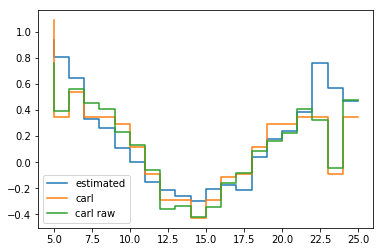

In [31]:
r_true = np.log(p_estimated_0[5:-5]) - np.log(p_estimated_1[5:-5])

x_test = to_categorical(np.array(range(n_nails)), num_classes=n_nails)
r_carl = np.log(carl_calibrated.predict(np.hstack([x_test,
                                 theta_0 * np.ones((n_nails, 1)), 
                                 theta_1 * np.ones((n_nails, 1))]))[0][5:-5])
r_carl_raw = log_r_from_s(carl.predict(np.hstack([x_test,
                                 theta_0 * np.ones((n_nails, 1)), 
                                 theta_1 * np.ones((n_nails, 1))]))[5:-5])


plt.step(range(5, n_nails-5), r_true, label="estimated")
plt.step(range(5, n_nails-5), r_carl, label="carl")
plt.step(range(5, n_nails-5), r_carl_raw, label="carl raw")

plt.legend()
plt.show()


# ROLR + RASCAL

In [32]:
from galton import check_random_state
from itertools import product

def draw_ratio(n_samples, n_thetas=10, random_state=0):
    grid = list(product(np.linspace(-1.0, -0.4, n_thetas), 
                        np.linspace(-1.0, -0.4, n_thetas)))
    n_traces_per_theta = n_samples // len(grid)
    
    rng = check_random_state(random_state)
    
    all_x = []
    all_log_r_xz = []
    all_t_xz_0 = []
    all_thetas = []

    # draw from theta_0
    for theta_0, theta_1 in grid:
        x, log_p_xz_0, log_p_xz_1, t_xz_0, _, _ = galton_rvs_ratio(theta_0, theta_1, 
                                                                   n_runs=n_traces_per_theta, random_state=rng)
        all_x.append(x)
        all_log_r_xz.append(log_p_xz_0 - log_p_xz_1)
        all_t_xz_0.append(t_xz_0)
        all_thetas.append(np.tile(np.array([theta_0, theta_1]), (n_traces_per_theta, 1)))
        
    # reshape
    all_x = np.array(all_x).reshape(-1, 1)
    all_x = to_categorical(all_x, num_classes=n_nails)
    all_log_r_xz = np.array(all_log_r_xz).reshape(-1, 1)
    all_t_xz_0 = np.array(all_t_xz_0).reshape(-1, 1)
    all_thetas = np.vstack(all_thetas)
    
    choices = rng.choice(len(all_x), len(all_x), replace=False)
        
    return all_x[choices], all_thetas[choices], all_log_r_xz[choices], all_t_xz_0[choices]

In [33]:
x, thetas, log_r_xz, t_xz_0 = draw_ratio(10000, n_thetas=10)

In [34]:
from keras.losses import mean_squared_error
from keras.layers import concatenate
from keras import losses

def make_rolr(lr=0.001):
    theta0 = Input(shape=(1,))
    theta1 = Input(shape=(1,))
    thetas = concatenate([theta0, theta1])
    
    h = Dense(hidden_size, activation="tanh")(thetas)
    log_rhat_thetas = Dense(n_outputs, activation="linear")(h)
    rhat_thetas = Lambda(lambda exp: K.exp(exp))(log_rhat_thetas)
    
    x = Input(shape=(n_outputs,))
    rhat_x_thetas = dot([x, rhat_thetas], axes=1)
    
    model = Model(inputs=[theta0, theta1, x], outputs=[rhat_x_thetas])
    opt = Adam(lr=lr)
    model.compile(loss=[inv_mse], optimizer=opt)
    
    return model

def inv_mse(y_true, y_pred):
    inverse_r_loss = losses.mean_squared_error((1./ K.clip(y_true, -10., 10.)),
                                               (1./ K.clip(y_pred, -10., 10.)))

    return inverse_r_loss


def make_rascal(lr=0.001):
    theta0 = Input(shape=(1,))
    theta1 = Input(shape=(1,))
    thetas = concatenate([theta0, theta1])
    
    h = Dense(hidden_size, activation="tanh")(thetas)
    log_rhat_thetas = Dense(n_outputs, activation="linear")(h)
    rhat_thetas = Lambda(lambda exp: K.exp(exp))(log_rhat_thetas)
    
    x = Input(shape=(n_outputs,))
    rhat_x_thetas = dot([x, rhat_thetas], axes=1)
    
    log_rhat_x_theta = dot([x, log_rhat_thetas], axes=1) 
    t_x_0 = Lambda(lambda exp: K.gradients(exp[0], [exp[1]])[0], 
                   output_shape=(n_features,))([log_rhat_x_theta, theta0])
    
    model = Model(inputs=[theta0, theta1, x], outputs=[rhat_x_thetas, t_x_0])
    opt = Adam(lr=lr)
    model.compile(loss=[inv_mse, "mse"], loss_weights=[1.0, 0.5], optimizer=opt)
    
    return model

In [35]:
rolr = make_rolr()
rolr.fit([thetas[:, 0], 
          thetas[:, 1], 
          x], 
         np.exp(log_r_xz), 
         batch_size=32, epochs=50)

Epoch 1/50
10000/10000 [==============================] - 0s - loss: 0.2718     
Epoch 2/50
10000/10000 [==============================] - 0s - loss: 0.2124     
Epoch 3/50
10000/10000 [==============================] - 0s - loss: 0.1808     
Epoch 4/50
10000/10000 [==============================] - 0s - loss: 0.1526     
Epoch 5/50
10000/10000 [==============================] - 0s - loss: 0.1339     
Epoch 6/50
10000/10000 [==============================] - 0s - loss: 0.1248     
Epoch 7/50
10000/10000 [==============================] - 0s - loss: 0.1182     
Epoch 8/50
10000/10000 [==============================] - 0s - loss: 0.1148     
Epoch 9/50
10000/10000 [==============================] - 0s - loss: 0.1120     
Epoch 10/50
10000/10000 [==============================] - 0s - loss: 0.1107     
Epoch 11/50
10000/10000 [==============================] - 0s - loss: 0.1094     
Epoch 12/50
10000/10000 [==============================] - 0s - loss: 0.1084     
Epoch 13/50
10000/10000 [

In [36]:
rascal = make_rascal()
rascal.fit([thetas[:, 0], 
            thetas[:, 1], 
            x], 
           [np.exp(log_r_xz), 
            t_xz_0], 
           batch_size=32, epochs=50)

Epoch 1/50
10000/10000 [==============================] - 0s - loss: 1.2915 - dot_7_loss: 0.2416 - lambda_12_loss: 2.0998     
Epoch 2/50
10000/10000 [==============================] - 0s - loss: 0.7906 - dot_7_loss: 0.1573 - lambda_12_loss: 1.2666     
Epoch 3/50
10000/10000 [==============================] - 0s - loss: 0.6898 - dot_7_loss: 0.1293 - lambda_12_loss: 1.1208     
Epoch 4/50
10000/10000 [==============================] - 0s - loss: 0.6645 - dot_7_loss: 0.1209 - lambda_12_loss: 1.0871     
Epoch 5/50
10000/10000 [==============================] - 0s - loss: 0.6500 - dot_7_loss: 0.1167 - lambda_12_loss: 1.0667     
Epoch 6/50
10000/10000 [==============================] - 0s - loss: 0.6392 - dot_7_loss: 0.1142 - lambda_12_loss: 1.0500     
Epoch 7/50
10000/10000 [==============================] - 0s - loss: 0.6299 - dot_7_loss: 0.1122 - lambda_12_loss: 1.0355     
Epoch 8/50
10000/10000 [==============================] - 0s - loss: 0.6219 - dot_7_loss: 0.1109 - lambda_12_lo

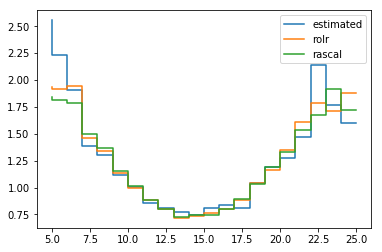

In [37]:
r_true = np.exp(np.log(p_estimated_0[5:-5]) - np.log(p_estimated_1[5:-5]))

x_test = to_categorical(np.array(range(n_nails)), num_classes=n_nails)
r_rolr = rolr.predict([theta_0 * np.ones(n_nails), 
                       theta_1 * np.ones(n_nails),
                       x_test])[5:-5]
r_rascal = rascal.predict([theta_0 * np.ones(n_nails),
                           theta_1 * np.ones(n_nails),
                           x_test])[0][5:-5]

plt.step(range(5, n_nails-5), r_true, label="estimated")
plt.step(range(5, n_nails-5), r_rolr, label="rolr")
plt.step(range(5, n_nails-5), r_rascal, label="rascal")
plt.legend()
plt.show()

---

# Model comparison

In [38]:
def compute_mse(p_train, p_estimated):
    p_ratio_train =  np.log(p_train[0]) - np.log(p_train[1])
    p_ratio = np.log(p_estimated[0]) - np.log(p_estimated[1])
    mse = p_ratio_train - p_ratio
    mse[np.logical_or(np.isinf(mse),np.isnan(mse))] = 0.
    mse = np.dot(mse**2, p_estimated[1])
    return mse
def compute_mse_ratio(ratio, p_estimated, log=True):
    p_ratio = np.log(p_estimated[0]) - np.log(p_estimated[1])
    if log:
        p_ratio_train = np.log(ratio)
    else:
        p_ratio_train = ratio
    mse = p_ratio_train - p_ratio
    mse[np.logical_or(np.isinf(mse),np.isnan(mse))] = 0.
    mse = np.dot(mse**2, p_estimated[1])
    return mse

In [56]:
mses_nde = []
mses_scandal = []
mses_carl = []
mses_carl_raw = []
mses_rolr = []
mses_rascal = []
p_estimated = np.array([p_estimated_0, p_estimated_1])
samples_size = [200,500,1000,2000,5000,10000]
x_test = to_categorical(np.array(range(n_nails)), num_classes=n_nails)
for n in samples_size:
    print('{0} Sample'.format(n))
    # NDE - SCANDAL
    x, t_xz, theta = draw(n)
    nde = make_nde()
    nde.fit(theta, x, batch_size=32, epochs=50, verbose=0)
    scandal = make_scandal()
    scandal.fit([theta, x], [x, t_xz], batch_size=32, epochs=50, verbose=0)
    nde_pred = nde.predict([theta_0, theta_1])
    scandal_pred = scandal.predict([np.array([[theta_0], [theta_1]]), np.zeros((2, n_nails))])[0]
    mse_nde = compute_mse(nde_pred, p_estimated)
    mse_scandal = compute_mse(scandal_pred, p_estimated)
    # CARL
    all_x, all_y = draw_parametrized(n//2, random_state=n)
    x_test = to_categorical(np.array(range(n_nails)), num_classes=n_nails)
    
    carl = KerasRegressor(make_carl, epochs=50, batch_size=256, verbose=0)

    carl.fit(all_x,all_y)

    carl_calibrated = ClassifierScoreRatio(
        CalibratedClassifierScoreCV(carl, cv='prefit', method='histogram', 
                                    bins=10 if n < 1000 else 20))
    carl_calibrated.fit(all_x, all_y.reshape(-1,1))
    carl_pred = carl_calibrated.predict(np.hstack([x_test,
                                 theta_0 * np.ones((n_nails, 1)), 
                                 theta_1 * np.ones((n_nails, 1))]))[0][5:-5]
    carl_raw_pred = log_r_from_s(carl.predict(np.hstack([x_test,
                                 theta_0 * np.ones((n_nails, 1)), 
                                 theta_1 * np.ones((n_nails, 1))]))[5:-5])
    mse_carl = compute_mse_ratio(carl_pred.flatten(), p_estimated[:,5:-5], log=True)
    mse_carl_raw = compute_mse_ratio(carl_raw_pred.flatten(), p_estimated[:,5:-5], log=False)
    # ROLR - RASCAL
    x, thetas, log_r_xz, t_xz_0 = draw_ratio(n, n_thetas=10)
    rolr = make_rolr()
    rolr.fit([thetas[:, 0], 
              thetas[:, 1], 
              x], 
             np.exp(log_r_xz), 
             batch_size=32, epochs=50, verbose=0)
    rascal = make_rascal()
    rascal.fit([thetas[:, 0], 
                thetas[:, 1], 
                x], 
               [np.exp(log_r_xz), 
                t_xz_0], 
               batch_size=32, epochs=50, verbose=0)
    rolr_pred = rolr.predict([theta_0 * np.ones(n_nails), 
                           theta_1 * np.ones(n_nails),
                           x_test])[5:-5]
    rascal_pred = rascal.predict([theta_0 * np.ones(n_nails),
                               theta_1 * np.ones(n_nails),
                               x_test])[0][5:-5]
    mse_rolr = compute_mse_ratio(rolr_pred.flatten(), p_estimated[:, 5:-5], log=True)
    mse_rascal = compute_mse_ratio(rascal_pred.flatten(), p_estimated[:, 5:-5], log=True)
    mses_nde.append(mse_nde)
    mses_rascal.append(mse_rascal)
    mses_carl.append(mse_carl)
    mses_carl_raw.append(mse_carl_raw)
    mses_rolr.append(mse_rolr)
    mses_scandal.append(mse_scandal)

200 Sample
500 Sample
1000 Sample
2000 Sample
5000 Sample
10000 Sample


In [57]:
from utils import calculate_height, adjust_margins

In [58]:
colors = ['','darkgreen', 'slateblue',  'c', '#CC002E', '0.5']
linestyles = ['',  ':', '--', ':', '-.', '--']
linewidths = [1.5 if ls == ':' else 1.5 for ls in linestyles]
markers    = [None] + ['o'] * 5

In [59]:
mses_nde = np.array(mses_nde)
mses_scandal = np.array(mses_scandal)
mses_rolr = np.array(mses_rolr)
mses_rascal = np.array(mses_rascal)
mses_carl = np.array(mses_carl)
mses_carl_raw = np.array(mses_carl_raw)

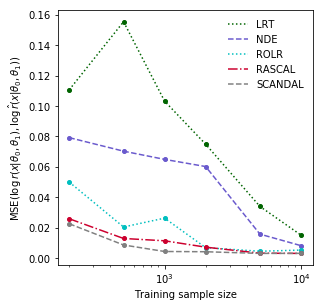

In [60]:
fig = plt.figure(figsize=(4.5,calculate_height(1,4.5,extra_top_space=False)))
ax = plt.gca()
samples_size = [200,500,1000,2000,5000,10000]

mses = [mses_carl_raw, mses_nde, mses_rolr, mses_rascal, mses_scandal]
labels = ['LRT', 'NDE', 'ROLR', 'RASCAL', 'SCANDAL']
s = 1
plt.plot(samples_size, mses[s-1], 
         ms=4., marker=markers[s],
         color=colors[s],
         lw=linewidths[s], ls=linestyles[s])
plt.plot([], [],
         color=colors[s],
         lw=linewidths[s], ls=linestyles[s],
         label=labels[s-1])

s = 2
plt.plot(samples_size, mses[s-1],
         ms=4., marker=markers[s],
         color=colors[s],
         lw=linewidths[s], ls=linestyles[s])
plt.plot([], [],
         color=colors[s],
         lw=linewidths[s], ls=linestyles[s],
         label=labels[s-1])

s = 3
plt.plot(samples_size, mses[s-1],
         ms=4., marker=markers[s],
         color=colors[s],
         lw=linewidths[s], ls=linestyles[s])
plt.plot([], [],
         color=colors[s],
         lw=linewidths[s], ls=linestyles[s],
         label=labels[s-1])

s = 4
plt.plot(samples_size, mses[s-1],
         ms=4., marker=markers[s],
         color=colors[s],
         lw=linewidths[s], ls=linestyles[s])
plt.plot([], [],
         color=colors[s],
         lw=linewidths[s], ls=linestyles[s],
         label=labels[s-1])

s = 5
plt.plot(samples_size, mses[s-1],
         ms=4., marker=markers[s],
         color=colors[s],
         lw=linewidths[s], ls=linestyles[s])
plt.plot([], [],
         color=colors[s],
         lw=linewidths[s], ls=linestyles[s],
         label=labels[s-1])

plt.legend(frameon=False)
ax.set_xscale("log", nonposx='clip')
#plt.ylim(-0.00, 0.165)
plt.xlabel(r"Training sample size")
plt.ylabel(r'MSE$(\log\,r(x|\theta_0, \theta_1),\log\,\hat{r}(x|\theta_0, \theta_1))$')

adjust_margins(1,4.5,extra_top_space=False)
#plt.savefig('plinko_models_comparison.pdf')